### Import Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import keras_tuner as kt
import os
import numpy as np
from matplotlib import pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import datetime

random.seed(1)
np.random.seed(1)

### Prepare EEG Train Data and Labels
This can take a few seconds, as there is a lot of data to load.

In [2]:
# cycle through all 16540 images
# cycle through each of the 4 reps
# save 17x100 array with image label
data_path = "THINGS_EEG_2"
num_subjects = 10

classes = ['00010_airplane', '00526_fish', '00060_banana_peel', '00160_bowling_ball', '00179_broccoli',
                '00437_dollhouse', '00409_daisy', '00432_dog', '00854_man', '00436_doll',
                '00616_grapefruit', '00978_panda', '01056_pizza', '00780_knot', '01628_wineglass',
                '01220_school_bus', '01320_soccer_ball', '00278_cherry', '01462_tennis_ball', '01477_tiger']
class_indices = []
class_names = []
for object in classes:
    split = object.split('_', 1)
    
    last_index = int(split[0])*10
    indices = list(range(last_index-10, last_index))
    class_indices.append(indices)
    
    obj_name = str(split[1])
    class_names.append(obj_name)

images = np.concatenate(class_indices).tolist()
num_classes = len(class_indices)

train_data_matrix = []
train_label_matrix = []
valid_data_matrix = []
valid_label_matrix = []
test_data_matrix = []
test_label_matrix = []

img_metadata = np.load(os.path.join(data_path, 'image_metadata.npy'), allow_pickle=True).item()

for sub in range(num_subjects):
    subject = sub+1
    print("Loading subject " + str(subject) + '...')
    eeg_data_train = np.load(os.path.join(data_path, 'sub-'+str(subject), 'preprocessed_eeg_training.npy'), allow_pickle=True).item()
    
    train_data_dim = eeg_data_train['preprocessed_eeg_data'].shape
    repitition = train_data_dim[1]
    
    i = 0
    for obj_type in class_indices:
        n = 1
        for im in obj_type:
            image_label = int(np.floor(i/10))
            split_choice = random.randint(0, 3)
            for rep in range(repitition):
                if rep == split_choice: # take one repitition of each image from each subject
                    trial_data = eeg_data_train['preprocessed_eeg_data'][im][rep]
                    if n%4==0 or n%5==0:
                        test_data_matrix.append(trial_data)
                        test_label_matrix.append(image_label)
                    else:
                        valid_data_matrix.append(trial_data)
                        valid_label_matrix.append(image_label)
                    n+=1
                else:
                    trial_data = eeg_data_train['preprocessed_eeg_data'][im][rep]
                    train_data_matrix.append(trial_data)
                    train_label_matrix.append(image_label)
            i += 1
    print("Done with subject " + str(subject))

train_data_matrix = np.array(train_data_matrix)
print(train_data_matrix.shape)

valid_data_matrix = np.array(valid_data_matrix)
print(valid_data_matrix.shape)

test_data_matrix = np.array(test_data_matrix)
print(test_data_matrix.shape)

Loading subject 1...
Done with subject 1
Loading subject 2...
Done with subject 2
Loading subject 3...
Done with subject 3
Loading subject 4...
Done with subject 4
Loading subject 5...
Done with subject 5
Loading subject 6...
Done with subject 6
Loading subject 7...
Done with subject 7
Loading subject 8...
Done with subject 8
Loading subject 9...
Done with subject 9
Loading subject 10...
Done with subject 10
(6000, 17, 100)
(1200, 17, 100)
(800, 17, 100)


### Randomize order of examples

In [3]:
indices = random.sample(range(len(train_data_matrix)), len(train_data_matrix))  # Get a shuffled list of indices
train_data_matrix = [train_data_matrix[i] for i in indices]  
train_label_matrix = [train_label_matrix[i] for i in indices]

indices = random.sample(range(len(valid_data_matrix)), len(valid_data_matrix))  # Get a shuffled list of indices
valid_data_matrix = [valid_data_matrix[i] for i in indices]  
valid_label_matrix = [valid_label_matrix[i] for i in indices]

indices = random.sample(range(len(test_data_matrix)), len(test_data_matrix))  # Get a shuffled list of indices
test_data_matrix = [test_data_matrix[i] for i in indices]  
test_label_matrix = [test_label_matrix[i] for i in indices]

#### Final Data Preparation

In [4]:
# Convert the data and labels to NumPy arrays
train_data_matrix = np.array(train_data_matrix)
valid_data_matrix = np.array(valid_data_matrix)
test_data_matrix = np.array(test_data_matrix)

train_label_matrix = np.array(train_label_matrix)
valid_label_matrix = np.array(valid_label_matrix)
test_label_matrix = np.array(test_label_matrix)

# Normalize data
train_data_matrix = train_data_matrix / np.linalg.norm(train_data_matrix, axis=(1,2), keepdims=True)
valid_data_matrix = valid_data_matrix / np.linalg.norm(valid_data_matrix, axis=(1,2), keepdims=True)
test_data_matrix = test_data_matrix / np.linalg.norm(test_data_matrix, axis=(1,2), keepdims=True)

# Reshape the input data to have the expected shape for the CNN
train_data_matrix = train_data_matrix.reshape(-1, 17, 100, 1)
valid_data_matrix = valid_data_matrix.reshape(-1, 17, 100, 1)
test_data_matrix = test_data_matrix.reshape(-1, 17, 100, 1)

# Ensure the input data is of type float32
train_data_matrix = train_data_matrix.astype('float32')
valid_data_matrix = valid_data_matrix.astype('float32')
test_data_matrix = test_data_matrix.astype('float32')

### Create the Model

In [15]:
# used for model_2025-05-10-02-01-08, the 16.5% one
model = models.Sequential()
model.add(layers.Input(shape=(17, 100, 1)))

model.add(layers.Conv2D(16, (3, 3), activation='softmax'))
model.add(layers.LayerNormalization())
model.add(layers.MaxPooling2D((3, 2)))
model.add(layers.SpatialDropout2D(0.25))

model.add(layers.Conv2D(40, (3, 3), activation='elu'))
model.add(layers.LayerNormalization())
model.add(layers.MaxPooling2D((3, 2)))
model.add(layers.SpatialDropout2D(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l1(0.0005)))
model.add(layers.Dense(num_classes, activation='softmax'))
model.summary()

'''
Best Hyperparameters Found:
 activation_0: softmax
 activation_1: elu
 activation_2 = elu
 dropout_rate_0 = 0.25
 dropout_rate_1 = 0.3
 conv_filters_0 = 16
 conv_filters_1 = 40
 reg_rate_0 = 0.0005
 hp_units_0 = 128
 learning rate = 0.0005.
 optimizer = Adam
'''

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 15, 98, 16)        160       
                                                                 
 layer_normalization_2 (Lay  (None, 15, 98, 16)        32        
 erNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 49, 16)         0         
 g2D)                                                            
                                                                 
 spatial_dropout2d_2 (Spati  (None, 5, 49, 16)         0         
 alDropout2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 47, 40)         5800      
                                                      

'\nBest Hyperparameters Found:\n activation_0: softmax\n activation_1: elu\n activation_2 = elu\n dropout_rate_0 = 0.25\n dropout_rate_1 = 0.3\n conv_filters_0 = 16\n conv_filters_1 = 40\n reg_rate_0 = 0.0005\n hp_units_0 = 128\n learning rate = 0.0005.\n optimizer = Adam\n'

### Tune the Model

In [ ]:
# for hyperparameter tuning
# if just training, run previous
def model_builder(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(17, 100, 1)))
    
    activation_0 = hp.Choice('activation_0', ['relu', 'elu', 'softmax', 'leaky_relu'])
    activation_1 = hp.Choice('activation_1', ['relu', 'elu', 'softmax', 'leaky_relu'])
    activation_2 = hp.Choice('activation_2', ['relu', 'elu', 'softmax', 'leaky_relu'])
    dropout_rate_0 = hp.Float('dropout_rate_0', min_value=0.25, max_value=0.50, step=0.05)
    dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.25, max_value=0.50, step=0.05)
    conv_filters_0 = hp.Int('conv_filters_0', min_value=8, max_value=64, step=8)
    conv_filters_1 = hp.Int('conv_filters_1', min_value=8, max_value=64, step=8)
    reg_rate_0 = hp.Choice('regularization_rate', [1e-2, 1e-3, 1e-4, 5e-2, 5e-3, 5e-4])
    hp_units_0 = hp.Int('units', min_value=16, max_value=256, step=16)
    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw','rmsprop', 'adadelta'])
    
    model.add(layers.Conv2D(conv_filters_0, kernel_size=(3, 3), activation=activation_0))
    model.add(layers.LayerNormalization())
    model.add(layers.MaxPooling2D((3, 2)))
    model.add(layers.SpatialDropout2D(dropout_rate_0))

    model.add(layers.Conv2D(conv_filters_1, kernel_size=(3, 3), activation=activation_1))
    model.add(layers.LayerNormalization())
    model.add(layers.MaxPooling2D((3, 2)))
    model.add(layers.SpatialDropout2D(dropout_rate_1))

    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp_units_0, activation=activation_2), kernel_regularizer=reg_rate_0)
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 5e-2, 5e-3, 5e-4])
    
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'adamw':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'adadelta':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [ ]:
date = str(datetime.datetime.now())[:19].replace(":", "-").replace(" ", "-")
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='tuning_' + date)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(train_data_matrix, train_label_matrix, epochs=30, validation_data=(valid_data_matrix, valid_label_matrix), callbacks=[callback])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
 activation_0: {best_hps.get('activation_0')}
 activation_1: {best_hps.get('activation_1')}
 activation_2 = {best_hps.get('activation_2')}
 dropout_rate_0 = {best_hps.get('dropout_rate_0')}
 dropout_rate_1 = {best_hps.get('dropout_rate_1')}
 conv_filters_0 = {best_hps.get('conv_filters_0')}
 conv_filters_1 = {best_hps.get('conv_filters_1')}
 reg_rate_0 = {best_hps.get('reg_rate_0')}
 hp_units_0 = {best_hps.get('units')}
 learning rate = {best_hps.get('learning_rate')}
 optimizer = {best_hps.get('optimizer')}
""")

Trial 30 Complete [00h 00m 43s]
val_accuracy: 0.05000000074505806

Best val_accuracy So Far: 0.14166666567325592
Total elapsed time: 00h 14m 56s

 activation_0: softmax
 activation_1: leaky_relu
 activation_2 = leaky_relu
 dropout_rate_0 = 0.25
 dropout_rate_1 = 0.4
 conv_filters_0 = 8
 conv_filters_1 = 56
 hp_units_0 = 128
 learning rate = 0.001
 optimizer = adadelta



### Compile and train the model

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data_matrix, train_label_matrix, epochs=30,
                    validation_data=(valid_data_matrix, valid_label_matrix),
                    callbacks=[callback])

Epoch 1/30
188/188 [==============================] - 7s 31ms/step - loss: 5.1198 - accuracy: 0.0540 - val_loss: 4.8349 - val_accuracy: 0.0567
Epoch 2/30
188/188 [==============================] - 5s 27ms/step - loss: 4.5865 - accuracy: 0.0720 - val_loss: 4.3758 - val_accuracy: 0.0842
Epoch 3/30
188/188 [==============================] - 5s 24ms/step - loss: 4.1564 - accuracy: 0.0887 - val_loss: 4.0204 - val_accuracy: 0.0800
Epoch 4/30
188/188 [==============================] - 4s 23ms/step - loss: 3.8114 - accuracy: 0.1053 - val_loss: 3.7212 - val_accuracy: 0.0792
Epoch 5/30
188/188 [==============================] - 5s 25ms/step - loss: 3.5548 - accuracy: 0.1140 - val_loss: 3.5497 - val_accuracy: 0.0983
Epoch 6/30
188/188 [==============================] - 4s 23ms/step - loss: 3.3788 - accuracy: 0.1198 - val_loss: 3.3696 - val_accuracy: 0.1083
Epoch 7/30
188/188 [==============================] - 5s 24ms/step - loss: 3.2545 - accuracy: 0.1317 - val_loss: 3.3022 - val_accuracy: 0.1083

### Evaluate the model

25/25 - 0s - loss: 3.0943 - accuracy: 0.1475 - 210ms/epoch - 8ms/step
Model test accuracy: 14.75%


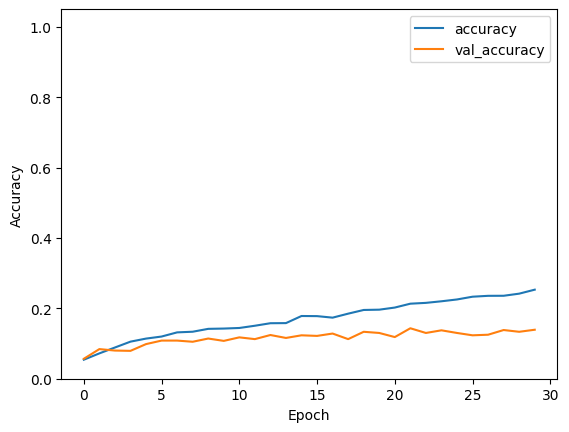

In [17]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.05])
plt.legend(loc='upper right')

loss, acc = model.evaluate(test_data_matrix, test_label_matrix, verbose=2)
print("Model test accuracy: {:5.2f}%".format(100 * acc))

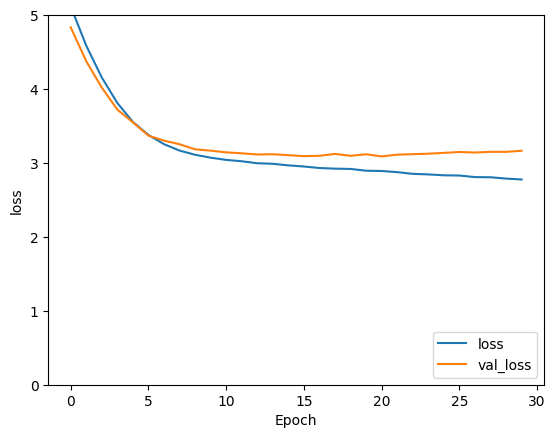

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss') 
plt.ylim([0, 5.0])
plt.legend(loc='lower right')

### Save results

In [ ]:
date = str(datetime.datetime.now())[:19].replace(":", "-").replace(" ", "-")

model.save('models/model_' + date)
last_saved_model_path = 'models/model_' + date

INFO:tensorflow:Assets written to: models/model_2025-05-15-21-28-24\assets


INFO:tensorflow:Assets written to: models/model_2025-05-15-21-28-24\assets


### Our best model

In [ ]:
model_name = 'models/model_2025-05-10-02-01-08'
loaded_model = tf.keras.models.load_model(model_name)

# Evaluate the model
loss, acc = loaded_model.evaluate(test_data_matrix, test_label_matrix, verbose=2)
print("Restored model accuracy: {:5.2f}%".format(100 * acc))

c:\Users\coolu\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


25/25 - 0s - loss: 2.6057 - accuracy: 0.3162 - 303ms/epoch - 12ms/step
Restored model accuracy: 31.62%


25/25 [==============================] - 0s 7ms/step


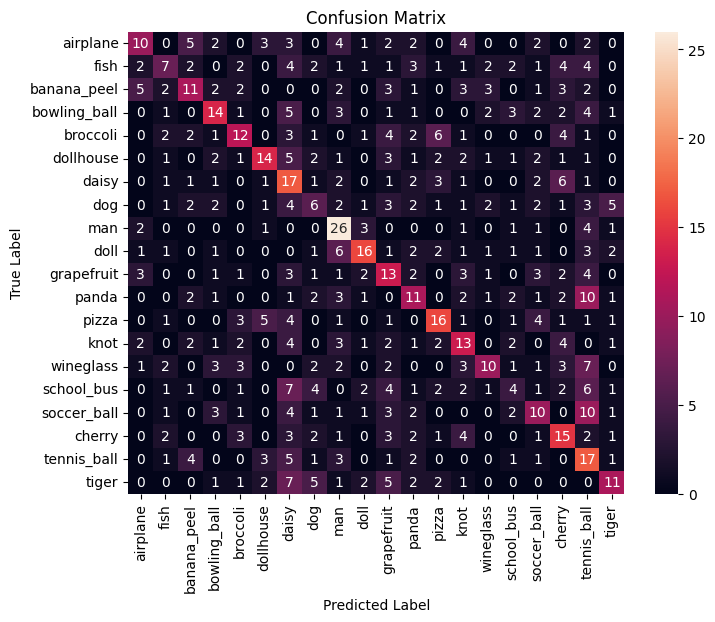

In [7]:
y_pred_probs = loaded_model.predict(test_data_matrix)

# Convert to predicted class labels (assuming softmax output)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert y_test to class labels if it's one-hot encoded
if test_label_matrix.ndim > 1 and test_label_matrix.shape[1] > 1:
    y_true = np.argmax(test_label_matrix, axis=1)
else:
    y_true = test_label_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',  xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()